In [1]:
# Author: Roi Yehoshua <roiyeho@gmail.com>
# License: MIT

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [4]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [5]:
train_score = reg.score(X_train, y_train)
print(f'R2 score (train): {train_score:.4f}')

test_score = reg.score(X_test, y_test)
print(f'R2 score (test): {test_score:.4f}')

R2 score (train): 0.8027
R2 score (test): 0.7774


Grid Search

In [6]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': np.arange(3, 11),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'max_features': ['sqrt', 'log2', None]    
}

search = RandomizedSearchCV(GradientBoostingRegressor(random_state=0), params, n_iter=50, cv=3, n_jobs=-1)
search.fit(X_train, y_train)

print(search.best_params_)

{'subsample': 0.7999999999999999, 'n_estimators': 500, 'max_features': 'log2', 'max_depth': 7}


In [7]:
best_reg = search.best_estimator_
print(f'R2 score (train): {best_reg.score(X_train, y_train):.4f}')
print(f'R2 score (test): {best_reg.score(X_test, y_test):.4f}')

R2 score (train): 0.9849
R2 score (test): 0.8519


Learning curve

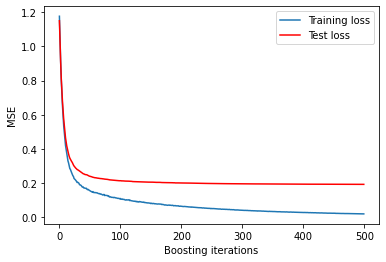

In [8]:
from sklearn.metrics import mean_squared_error as MSE

test_score = np.zeros(best_reg.n_estimators_)
for i, y_test_pred in enumerate(best_reg.staged_predict(X_test)):
    test_score[i] = MSE(y_test, y_test_pred)
    
plt.plot(np.arange(best_reg.n_estimators), best_reg.train_score_, label='Training loss')
plt.plot(np.arange(best_reg.n_estimators), test_score, 'r', label='Test loss')

plt.xlabel('Boosting iterations')
plt.ylabel('MSE')
plt.legend()

plt.savefig('figures/california_gbdt_learning_curve.pdf')

Using Early Stopping

In [9]:
from sklearn.model_selection import RandomizedSearchCV

params = {    
    'max_depth': np.arange(3, 11),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'max_features': ['sqrt', 'log2', None]    
}

search = RandomizedSearchCV(GradientBoostingRegressor(random_state=0, n_estimators=500, n_iter_no_change=5), 
                            params, n_iter=50, cv=3, n_jobs=-1)
search.fit(X_train, y_train)

print(search.best_params_)

reg = search.best_estimator_
print(f'R2 score (train): {reg.score(X_train, y_train):.4f}')
print(f'R2 score (test): {reg.score(X_test, y_test):.4f}')

{'subsample': 0.8999999999999999, 'max_features': 'log2', 'max_depth': 7}
R2 score (train): 0.9227
R2 score (test): 0.8402


In [10]:
reg.n_estimators_

118

Feature importance

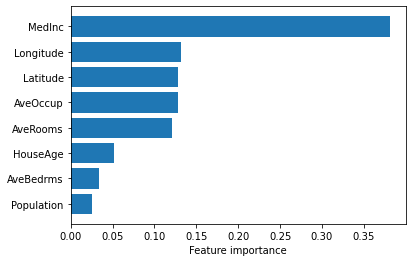

In [11]:
# Sort the features by their importance
feature_importance = best_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot the feature importances
pos = np.arange(len(feature_importance))
plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.xlabel('Feature importance')

plt.savefig('figures/california_gbdt_feature_importance.pdf', bbox_inches='tight')